# 双稳态基因调控网络模拟

本 notebook 实现了一个 **互相抑制的 toggle switch 模型**，展示：
- **(a)** 互相抑制模型的数学定义
- **(b)** A/B 随时间变化的轨迹
- **(c)** A-B 状态空间散点，用颜色表示时间


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 设置更好看的绘图风格
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12


## 1) 模型定义：互相抑制的 toggle switch

数学模型：
$$\frac{dA}{dt} = \alpha_A \cdot \text{repress}(B) - \delta_A \cdot A$$
$$\frac{dB}{dt} = \alpha_B \cdot \text{repress}(A) - \delta_B \cdot B$$

其中 Hill 抑制函数为：
$$\text{repress}(x) = \frac{1}{1 + (x/K)^n}$$


In [2]:
def hill_repress(x, K=20.0, n=4.0):
    """Hill 抑制函数：x 越大，输出越接近 0"""
    return 1.0 / (1.0 + (x / K) ** n)


def simulate_toggle(
    T=5.0, dt=1e-3,
    alphaA=60.0, alphaB=60.0,
    deltaA=1.0, deltaB=1.0,
    K=20.0, n=4.0,
    A0=5.0, B0=40.0,
    noise=0.0,
    alphaA_schedule=None
):
    """
    模拟 toggle switch 动力学
    
    dA/dt = alphaA * repress(B) - deltaA * A
    dB/dt = alphaB * repress(A) - deltaB * B
    
    Parameters:
    -----------
    noise: 简单高斯噪声强度（教学用）
    alphaA_schedule: 如果传入函数 alphaA_schedule(t)，则 alphaA 随时间变化
    """
    steps = int(T / dt) + 1
    t = np.linspace(0, T, steps)
    A = np.zeros(steps)
    B = np.zeros(steps)
    A[0], B[0] = A0, B0
    
    for i in range(steps - 1):
        aA = alphaA_schedule(t[i]) if alphaA_schedule else alphaA
        aB = alphaB
        
        dA = aA * hill_repress(B[i], K, n) - deltaA * A[i]
        dB = aB * hill_repress(A[i], K, n) - deltaB * B[i]
        
        # 教学用噪声项（不是严格的化学主方程/Gillespie）
        if noise > 0:
            dA += noise * np.random.randn()
            dB += noise * np.random.randn()
        
        A[i + 1] = max(0.0, A[i] + dt * dA)
        B[i + 1] = max(0.0, B[i] + dt * dB)
    
    return t, A, B


## 2) 展示"什么是双稳态"

用不同初值跑同一套参数，会收敛到不同稳态


In [3]:
params = dict(alphaA=60, alphaB=60, K=20, n=4, deltaA=1, deltaB=1)

# 两组明显偏向的初值
t1, A1, B1 = simulate_toggle(A0=40, B0=5,  **params)
t2, A2, B2 = simulate_toggle(A0=5,  B0=40, **params)

# 在"中间附近"给一点点不对称扰动
t3, A3, B3 = simulate_toggle(A0=10,  B0=10.1, **params)
t4, A4, B4 = simulate_toggle(A0=10.1, B0=10,  **params)


/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/747552184.py:23: UserWarning: Glyph 21021 (\N{CJK UNIFIED IDEOGRAPH-521D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/747552184.py:23: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/747552184.py:23: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/747552184.py:23: UserWarning: Glyph 21521 (\N{CJK UNIFIED IDEOGRAPH-5411}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/747552184.py:23: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412

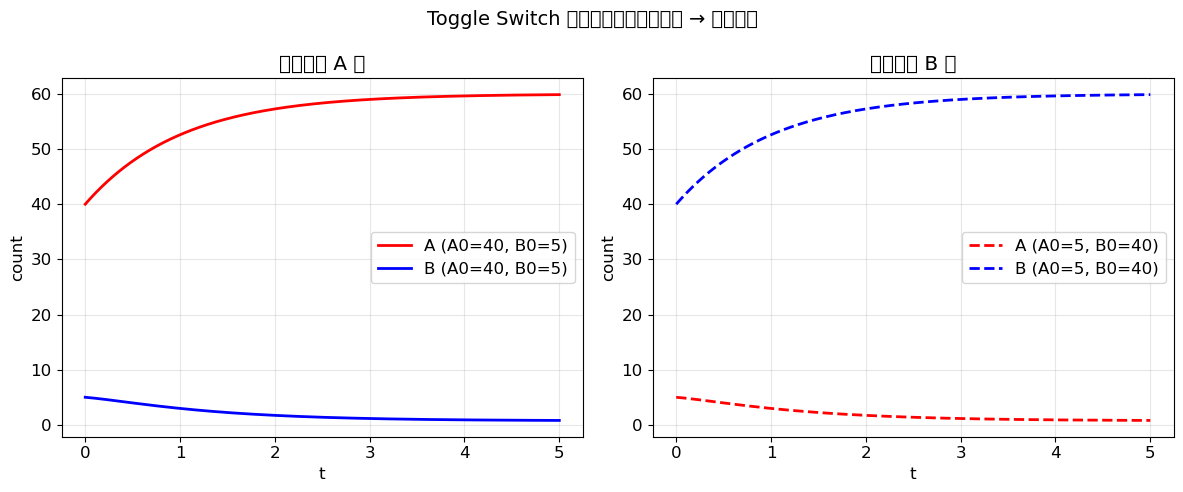

In [4]:
# (b) 风格的时间轨迹
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t1, A1, 'r-', linewidth=2, label="A (A0=40, B0=5)")
plt.plot(t1, B1, 'b-', linewidth=2, label="B (A0=40, B0=5)")
plt.xlabel("t")
plt.ylabel("count")
plt.title("初值偏向 A 高")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(t2, A2, 'r--', linewidth=2, label="A (A0=5, B0=40)")
plt.plot(t2, B2, 'b--', linewidth=2, label="B (A0=5, B0=40)")
plt.xlabel("t")
plt.ylabel("count")
plt.title("初值偏向 B 高")
plt.legend()
plt.grid(alpha=0.3)

plt.suptitle("Toggle Switch 双稳态演示：不同初值 → 不同稳态", fontsize=14)
plt.tight_layout()
plt.show()


In [6]:
print("=" * 50)
print("最终稳态结果：")
print("=" * 50)
print(f"初值 (40, 5)  → 终态: A = {A1[-1]:.2f}, B = {B1[-1]:.2f}")
print(f"初值 (5, 40)  → 终态: A = {A2[-1]:.2f}, B = {B2[-1]:.2f}")
print(f"初值 (10, 10.1) → 终态: A = {A3[-1]:.2f}, B = {B3[-1]:.2f}")
print(f"初值 (10.1, 10) → 终态: A = {A4[-1]:.2f}, B = {B4[-1]:.2f}")
print("\n→ 可以看到：微小的初值差异导致完全不同的命运！")


最终稳态结果：
初值 (40, 5)  → 终态: A = 59.86, B = 0.80
初值 (5, 40)  → 终态: A = 0.80, B = 59.86
初值 (10, 10.1) → 终态: A = 4.84, B = 52.64
初值 (10.1, 10) → 终态: A = 52.64, B = 4.84

→ 可以看到：微小的初值差异导致完全不同的命运！


## 3) 分岔过程演示

让 αA 随时间缓慢上升，模拟"参数漂移导致的命运转变"


In [7]:
def alphaA_sched(t, T_total=5.0):
    """αA 从 30 线性升到 90"""
    return 30.0 + 60.0 * (t / T_total)

T_total = 5.0
t, A, B = simulate_toggle(
    T=T_total, dt=1e-3,
    alphaB=60,
    alphaA_schedule=lambda x: alphaA_sched(x, T_total),
    A0=5, B0=40,
    K=20, n=4,
    noise=0.0  # 先不加噪声
)


/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/2928597868.py:24: UserWarning: Glyph 36712 (\N{CJK UNIFIED IDEOGRAPH-8F68}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/2928597868.py:24: UserWarning: Glyph 36857 (\N{CJK UNIFIED IDEOGRAPH-8FF9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/2928597868.py:24: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/2928597868.py:24: UserWarning: Glyph 32531 (\N{CJK UNIFIED IDEOGRAPH-7F13}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/2928597868.py:24: UserWarning: Glyph 24930 (\N{CJK UNIFIED IDEOGRAPH-6162}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3d

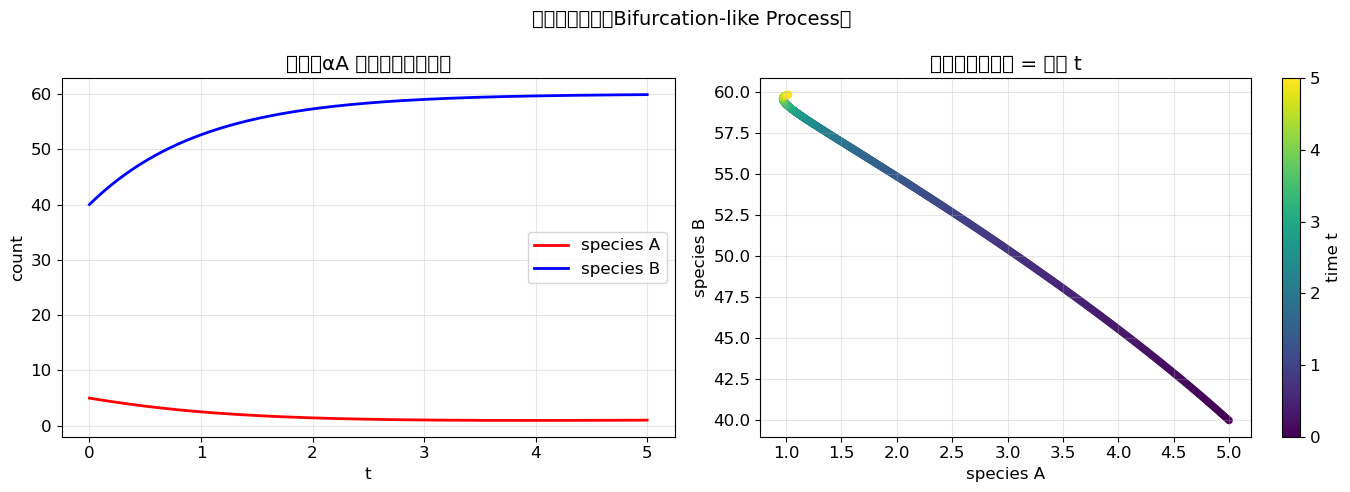

In [8]:
# (b) 分岔驱动下的轨迹（无噪声）
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：时间轨迹
ax1 = axes[0]
ax1.plot(t, A, 'r-', linewidth=2, label="species A")
ax1.plot(t, B, 'b-', linewidth=2, label="species B")
ax1.set_xlabel("t")
ax1.set_ylabel("count")
ax1.set_title("轨迹：αA 缓慢变化导致分岔")
ax1.legend()
ax1.grid(alpha=0.3)

# 右图：(c) 状态空间散点，颜色表示时间
ax2 = axes[1]
sc = ax2.scatter(A[::5], B[::5], c=t[::5], s=20, cmap='viridis')
ax2.set_xlabel("species A")
ax2.set_ylabel("species B")
ax2.set_title("状态空间：颜色 = 时间 t")
plt.colorbar(sc, ax=ax2, label="time t")
ax2.grid(alpha=0.3)

plt.suptitle("分岔过程演示（Bifurcation-like Process）", fontsize=14)
plt.tight_layout()
plt.show()


## 4) 可选：加噪声，更像"随机分子轨迹"


/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/1821704632.py:33: UserWarning: Glyph 24102 (\N{CJK UNIFIED IDEOGRAPH-5E26}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/1821704632.py:33: UserWarning: Glyph 22122 (\N{CJK UNIFIED IDEOGRAPH-566A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/1821704632.py:33: UserWarning: Glyph 22768 (\N{CJK UNIFIED IDEOGRAPH-58F0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/1821704632.py:33: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/1821704632.py:33: UserWarning: Glyph 36712 (\N{CJK UNIFIED IDEOGRAPH-8F68}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90l

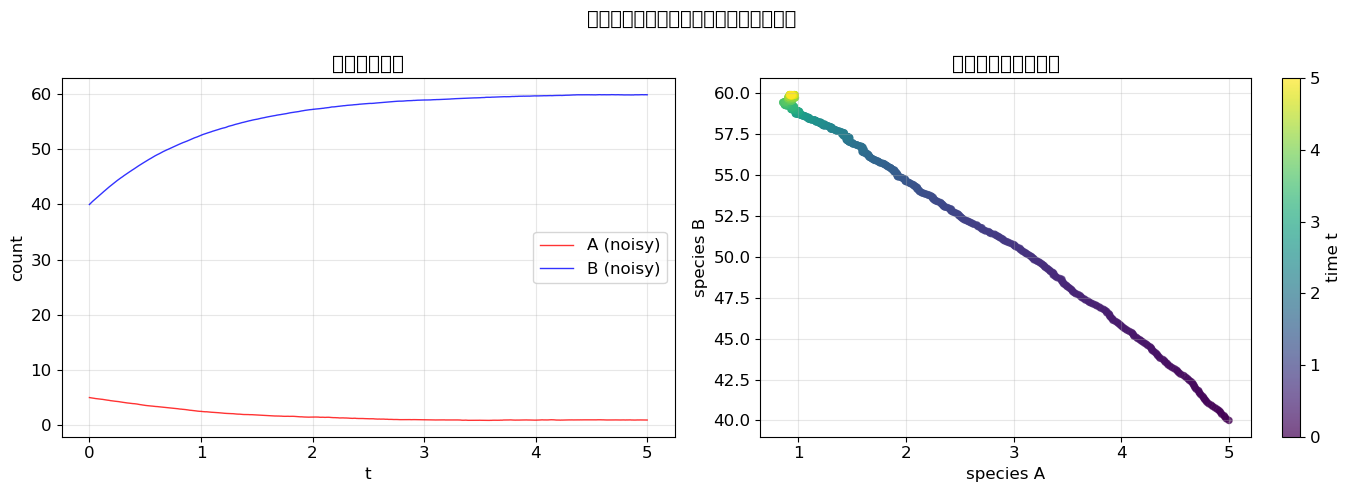

In [9]:
# 带噪声的模拟
tN, AN, BN = simulate_toggle(
    T=T_total, dt=1e-3,
    alphaB=60,
    alphaA_schedule=lambda x: alphaA_sched(x, T_total),
    A0=5, B0=40,
    K=20, n=4,
    noise=3.0
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：噪声轨迹
ax1 = axes[0]
ax1.plot(tN, AN, 'r-', alpha=0.8, linewidth=1, label="A (noisy)")
ax1.plot(tN, BN, 'b-', alpha=0.8, linewidth=1, label="B (noisy)")
ax1.set_xlabel("t")
ax1.set_ylabel("count")
ax1.set_title("带噪声的轨迹")
ax1.legend()
ax1.grid(alpha=0.3)

# 右图：噪声状态空间
ax2 = axes[1]
sc = ax2.scatter(AN[::5], BN[::5], c=tN[::5], s=20, cmap='viridis', alpha=0.7)
ax2.set_xlabel("species A")
ax2.set_ylabel("species B")
ax2.set_title("状态空间（带噪声）")
plt.colorbar(sc, ax=ax2, label="time t")
ax2.grid(alpha=0.3)

plt.suptitle("噪声轨迹演示（更接近随机分子动力学）", fontsize=14)
plt.tight_layout()
plt.show()


## 5) 多轨迹采样：类似图 1.3(c) 的效果

从多个随机初值出发，模拟多条轨迹，更好地展示分岔过程中的状态空间分布


/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/1611904433.py:36: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/1611904433.py:36: UserWarning: Glyph 36712 (\N{CJK UNIFIED IDEOGRAPH-8F68}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/1611904433.py:36: UserWarning: Glyph 36857 (\N{CJK UNIFIED IDEOGRAPH-8FF9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/1611904433.py:36: UserWarning: Glyph 29366 (\N{CJK UNIFIED IDEOGRAPH-72B6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/1611904433.py:36: UserWarning: Glyph 24577 (\N{CJK UNIFIED IDEOGRAPH-6001}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90l

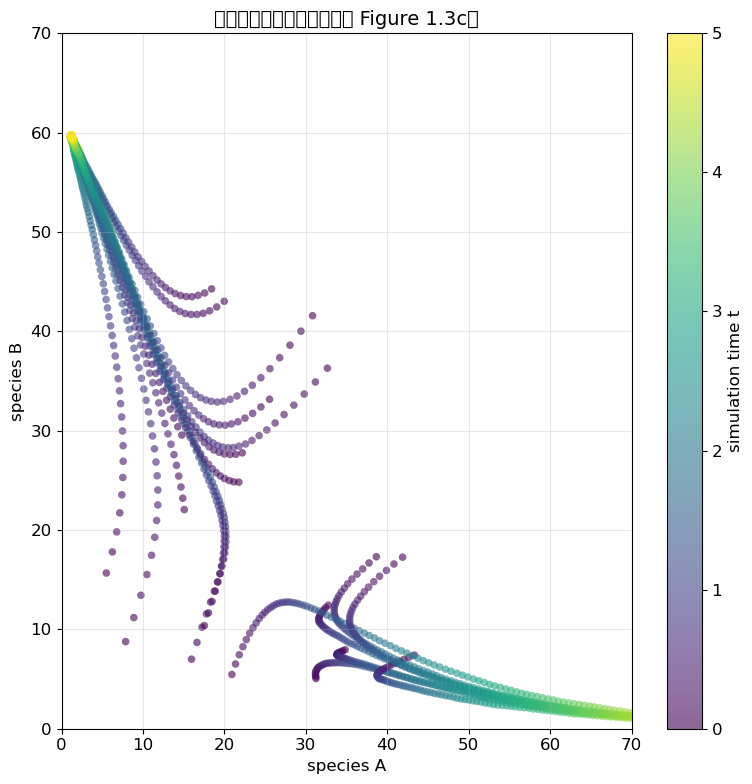

In [10]:
# 从多个随机初值出发，模拟多条轨迹
np.random.seed(42)

fig, ax = plt.subplots(figsize=(8, 8))

all_A, all_B, all_t = [], [], []

for _ in range(20):
    # 随机初值在 [5, 45] 范围
    A0 = np.random.uniform(5, 45)
    B0 = np.random.uniform(5, 45)
    
    t_traj, A_traj, B_traj = simulate_toggle(
        T=T_total, dt=1e-3,
        alphaB=60,
        alphaA_schedule=lambda x: alphaA_sched(x, T_total),
        A0=A0, B0=B0,
        K=20, n=4,
        noise=2.0
    )
    
    # 每隔50步采样
    all_A.extend(A_traj[::50])
    all_B.extend(B_traj[::50])
    all_t.extend(t_traj[::50])

sc = ax.scatter(all_A, all_B, c=all_t, s=30, cmap='viridis', alpha=0.6, edgecolors='none')
ax.set_xlabel("species A", fontsize=12)
ax.set_ylabel("species B", fontsize=12)
ax.set_title("多轨迹状态空间采样（类似 Figure 1.3c）", fontsize=14)
plt.colorbar(sc, ax=ax, label="simulation time t")
ax.grid(alpha=0.3)
ax.set_xlim(0, 70)
ax.set_ylim(0, 70)

plt.tight_layout()
plt.show()


---

## 总结

通过这个 notebook，我们展示了：

1. **双稳态现象**：相同参数、不同初值 → 收敛到不同稳态
2. **分岔过程**：参数随时间变化会导致系统"命运转变"
3. **噪声效应**：添加噪声让轨迹更接近真实的随机分子动力学

### 下一步

如果想要更严格的随机模拟，可以实现 **Gillespie SSA** 算法。


---

## 6) Gillespie SSA：精确随机模拟

前面的 ODE 模拟是**确定性**的，产生光滑曲线。而论文中 Figure 1.3(b) 使用的是 **Gillespie 算法**（Stochastic Simulation Algorithm），它：

- 把分子数建模为**离散整数**
- 每个反应（产生/降解）是独立的**随机事件**
- 反应之间的等待时间服从**指数分布**
- 精确采样自 **Chemical Master Equation (CME)**

这会产生内禀的随机涨落，更接近真实的分子动力学。
- Gillespie 不是ODE + noise，本质区别：Gillespie 模拟的是一个 跳跃过程（Jump Process），不是连续微分！

In [11]:
def gillespie_toggle_switch(
    T_max=1.0,
    alpha_A=300.0, alpha_B=300.0,
    delta_A=1.0, delta_B=1.0,
    K=150.0, n=4.0,
    A0=100, B0=100
):
    """
    Gillespie SSA for mutual repression toggle switch.
    
    Reactions:
    1. ∅ → A  (production of A, repressed by B)
    2. A → ∅  (degradation of A)
    3. ∅ → B  (production of B, repressed by A)
    4. B → ∅  (degradation of B)
    
    Parameters:
    -----------
    T_max : float
        Maximum simulation time
    alpha_A, alpha_B : float
        Maximum production rates
    delta_A, delta_B : float
        Degradation rates
    K : float
        Hill function threshold
    n : float
        Hill coefficient
    A0, B0 : int
        Initial molecule counts
    """
    
    def hill_repress(x, K, n):
        return 1.0 / (1.0 + (x / K) ** n)
    
    # Initial state
    A, B = A0, B0
    t = 0.0
    
    # Record trajectory
    times = [t]
    A_traj = [A]
    B_traj = [B]
    
    while t < T_max:
        # Calculate propensities (reaction rates)
        a1 = alpha_A * hill_repress(B, K, n)  # A production
        a2 = delta_A * A                       # A degradation
        a3 = alpha_B * hill_repress(A, K, n)  # B production
        a4 = delta_B * B                       # B degradation
        
        a_total = a1 + a2 + a3 + a4
        
        if a_total == 0:
            break
        
        # Time to next reaction (exponential distribution)
        tau = np.random.exponential(1.0 / a_total)
        t += tau
        
        if t > T_max:
            break
        
        # Which reaction fires? (proportional to propensity)
        r = np.random.random() * a_total
        
        if r < a1:
            A += 1              # A produced
        elif r < a1 + a2:
            A = max(0, A - 1)   # A degraded
        elif r < a1 + a2 + a3:
            B += 1              # B produced
        else:
            B = max(0, B - 1)   # B degraded
        
        # Record state
        times.append(t)
        A_traj.append(A)
        B_traj.append(B)
    
    return np.array(times), np.array(A_traj), np.array(B_traj)

print("Gillespie SSA 函数已定义 ✓")


Gillespie SSA 函数已定义 ✓


In [12]:
# 运行 Gillespie SSA 模拟
np.random.seed(123)

t_ssa, A_ssa, B_ssa = gillespie_toggle_switch(
    T_max=1.0,
    alpha_A=300, alpha_B=300,
    K=150, n=4,
    A0=100, B0=100
)

print(f"模拟完成：共 {len(t_ssa)} 个反应事件")
print(f"最终状态：A = {A_ssa[-1]}, B = {B_ssa[-1]}")


模拟完成：共 663 个反应事件
最终状态：A = 159, B = 121


/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/3566832389.py:31: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/3566832389.py:31: UserWarning: Glyph 25311 (\N{CJK UNIFIED IDEOGRAPH-62DF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/3566832389.py:31: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/3566832389.py:31: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/3566832389.py:31: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90l

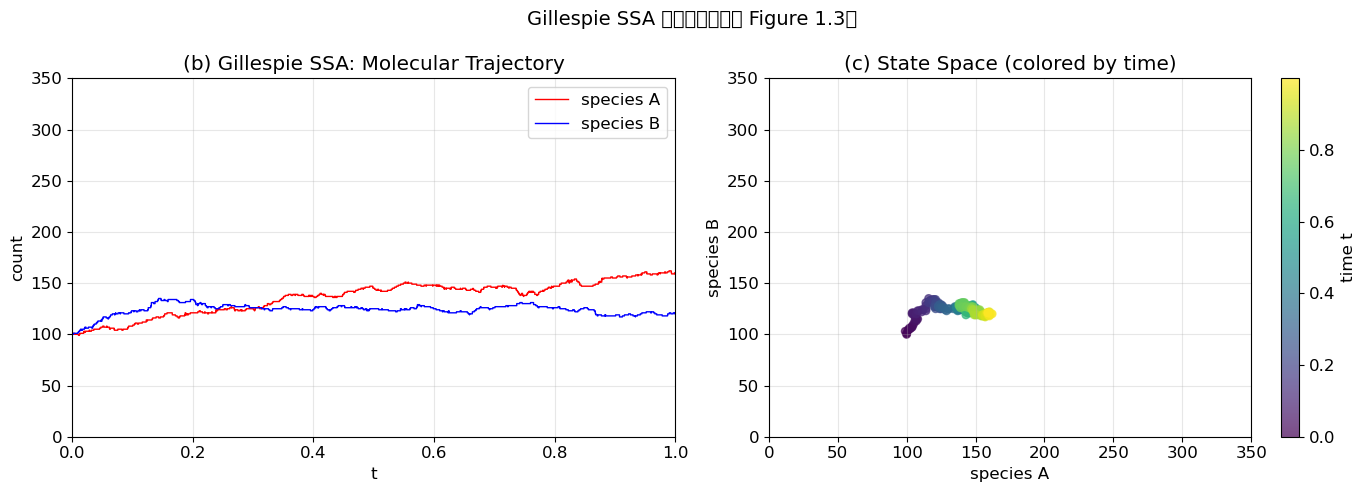

In [13]:
# 绘制 Gillespie SSA 结果 - 类似 Figure 1.3(b)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (b) 时间轨迹 - 使用阶梯图展示离散跳跃
ax1 = axes[0]
ax1.step(t_ssa, A_ssa, 'r-', where='post', linewidth=1, label='species A')
ax1.step(t_ssa, B_ssa, 'b-', where='post', linewidth=1, label='species B')
ax1.set_xlabel('t')
ax1.set_ylabel('count')
ax1.set_title('(b) Gillespie SSA: Molecular Trajectory')
ax1.legend()
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 350)
ax1.grid(alpha=0.3)

# (c) 状态空间散点，颜色表示时间
ax2 = axes[1]
# 均匀采样一些点用于散点图
sample_idx = np.linspace(0, len(t_ssa)-1, min(200, len(t_ssa))).astype(int)
sc = ax2.scatter(A_ssa[sample_idx], B_ssa[sample_idx], c=t_ssa[sample_idx], 
                  s=30, cmap='viridis', alpha=0.7)
ax2.set_xlabel('species A')
ax2.set_ylabel('species B')
ax2.set_title('(c) State Space (colored by time)')
plt.colorbar(sc, ax=ax2, label='time t')
ax2.set_xlim(0, 350)
ax2.set_ylim(0, 350)
ax2.grid(alpha=0.3)

plt.suptitle('Gillespie SSA 模拟结果（对应 Figure 1.3）', fontsize=14)
plt.tight_layout()
plt.show()


### 多轨迹采样：展示分岔过程

运行多条 Gillespie 轨迹，在状态空间中展示分岔行为：


/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/3926944419.py:42: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/3926944419.py:42: UserWarning: Glyph 36712 (\N{CJK UNIFIED IDEOGRAPH-8F68}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/3926944419.py:42: UserWarning: Glyph 36857 (\N{CJK UNIFIED IDEOGRAPH-8FF9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/3926944419.py:42: UserWarning: Glyph 29366 (\N{CJK UNIFIED IDEOGRAPH-72B6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/3926944419.py:42: UserWarning: Glyph 24577 (\N{CJK UNIFIED IDEOGRAPH-6001}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90l

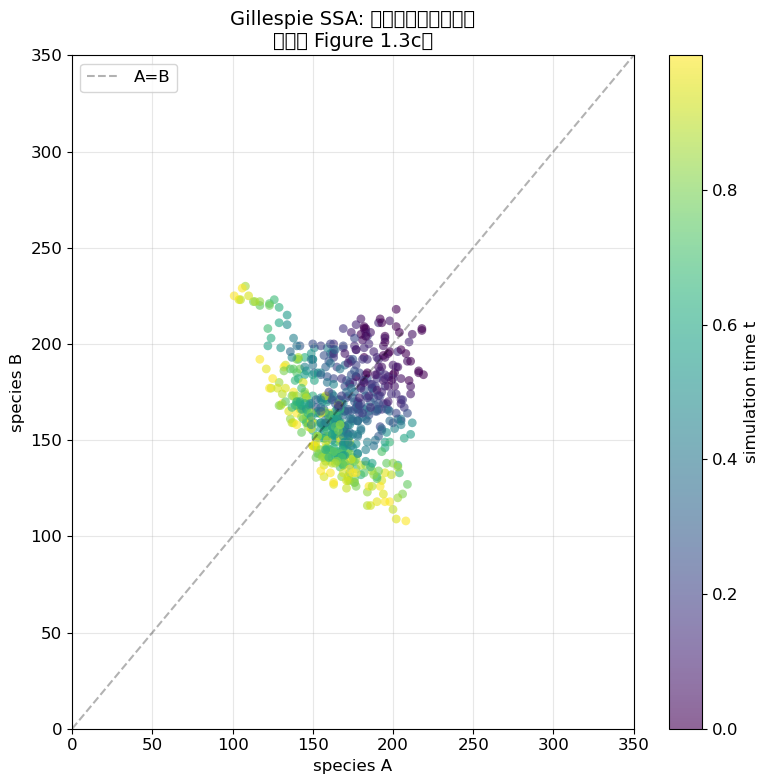

共采样 600 个状态点


In [14]:
# 多轨迹 Gillespie SSA，更好地展示 Figure 1.3(c) 的效果
np.random.seed(42)

fig, ax = plt.subplots(figsize=(8, 8))

all_A, all_B, all_t = [], [], []

# 运行 30 条轨迹
for i in range(30):
    # 从相似的初值出发
    A0 = np.random.randint(180, 220)
    B0 = np.random.randint(180, 220)
    
    t_traj, A_traj, B_traj = gillespie_toggle_switch(
        T_max=1.0,
        alpha_A=300, alpha_B=300,
        K=150, n=4,
        A0=A0, B0=B0
    )
    
    # 每条轨迹均匀采样约 20 个点
    n_samples = min(20, len(t_traj))
    idx = np.linspace(0, len(t_traj)-1, n_samples).astype(int)
    
    all_A.extend(A_traj[idx])
    all_B.extend(B_traj[idx])
    all_t.extend(t_traj[idx])

sc = ax.scatter(all_A, all_B, c=all_t, s=40, cmap='viridis', alpha=0.6, edgecolors='none')
ax.set_xlabel('species A', fontsize=12)
ax.set_ylabel('species B', fontsize=12)
ax.set_title('Gillespie SSA: 多轨迹状态空间采样\n（类似 Figure 1.3c）', fontsize=14)
plt.colorbar(sc, ax=ax, label='simulation time t')
ax.set_xlim(0, 350)
ax.set_ylim(0, 350)
ax.grid(alpha=0.3)

# 添加对角线参考
ax.plot([0, 350], [0, 350], 'k--', alpha=0.3, label='A=B')
ax.legend()

plt.tight_layout()
plt.show()

print(f"共采样 {len(all_A)} 个状态点")


---

## 总结：ODE vs Gillespie SSA

| 特性 | 确定性 ODE | Gillespie SSA |
|------|-----------|---------------|
| **状态变量** | 连续实数（浓度） | 离散整数（分子数） |
| **轨迹形态** | 光滑曲线 | 阶梯状涨落 |
| **随机性** | 无（除非手动加噪声） | 内禀随机性 |
| **理论基础** | 反应速率方程 | Chemical Master Equation |
| **适用场景** | 分子数很大时 | 分子数较少、随机效应重要时 |
| **计算效率** | 快（固定步长） | 较慢（事件驱动） |

**关键洞察**：当分子数 N 很大时，Gillespie SSA 的相对涨落 ~ 1/√N 会变小，轨迹会趋近 ODE 解（这就是"热力学极限"）。
